In [2]:
from Binaries import *
from scipy.optimize import curve_fit

# For VEM Peak

0/798 nuria_randoms0001.csv: 10000 traces
1/798 nuria_randoms0002.csv: 10000 traces
2/798 nuria_randoms0003.csv: 10000 traces


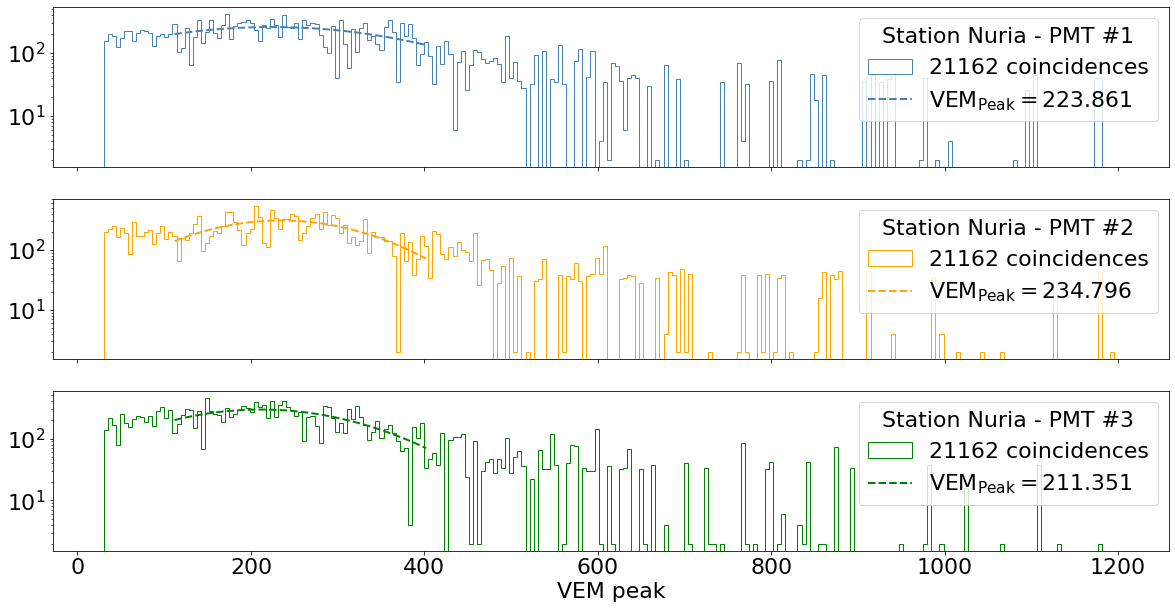

In [5]:
peak_evolution = []
cut_threshold = 30
leading_bins = 20
trailing_bins = 49
multiplicity = 1
dead_time = trailing_bins
combine_files = 3
station_name = "nuria"

mode = "peak"

if mode == "peak":

    x_range = (cut_threshold, 1200)
    i, f = 17, 80
    func = max
    min_vem = 120

elif mode == "charge":

    x_range = (cut_threshold, 12000)
    i, f = 20, 70
    func = sum
    min_vem = 1000

first_trigger = lambda x : np.argmax(x > cut_threshold)

def gauss(x, mu, A, sigma):

    return A * np.exp( -(x - mu)**2 / (2 * sigma**2) )

colors = ["steelblue", "orange", "green"]

h1, h2, h3 = [], [], []

for index in range(0, len(os.listdir(f"/cr/tempdata01/filip/iRODS/{station_name}/")), 3):

    for increment in range(combine_files):

        Buffer = RandomTrace(station_name, index + increment)
        
        vem_peak = []

        print(f"{index + increment}/{Buffer.all_n_files} {Buffer.random_file}: {len(Buffer._these_traces)} traces" )

        station = np.array(Buffer._these_traces)
        pmt1, pmt2, pmt3 = station[:,0], station[:,1], station[:,2]
        cut_mask = np.logical_and(np.any(pmt1 > cut_threshold, axis = 1), np.any(pmt2 > cut_threshold, axis = 1), np.any(pmt3 > cut_threshold, axis = 1))

        for (p1, p2, p3) in zip(pmt1[cut_mask], pmt2[cut_mask], pmt3[cut_mask]):

            # STRONG COINCIDENCE
            for step in range(min([first_trigger(p1), first_trigger(p2), first_trigger(p3)]), 2048):

                trigger_list = [p1[step] > cut_threshold, p1[step] > cut_threshold, p1[step] > cut_threshold]

                if trigger_list.count(True) >= multiplicity:

                    start, stop = max(0, step - leading_bins), min(2048, step + trailing_bins)

                    p1_data, p2_data, p3_data = p1[start : stop], p2[start : stop], p3[start : stop]
                    h1.append(func(p1_data)), h2.append(func(p2_data)), h3.append(func(p3_data))
                    
                    step += dead_time       # keep iterating
                    # break                     # stop after first hit
        
            # # WEAK COINCIDENCE
            # trigger_bin = np.argmax(p1 > cut_threshold)
            # start = max(0, trigger_bin - leading_bins)
            # stop = min(trigger_bin + trailing_bins, 2048)

            # p1_data, p2_data, p3_data = p1[start : stop], p2[start : stop], p3[start : stop]

            # if np.any(p2_data > cut_threshold) and np.any(p3_data > cut_threshold):

            #     h1.append(func(p1_data)), h2.append(func(p2_data)), h3.append(func(p3_data))

    fig, axes = plt.subplots(3, 1, sharex = True)
    name = Buffer.random_file.split("_")[0]

    try:
        for j, histogram in enumerate([h1, h2, h3]):

            n, bins, _ = axes[j].hist(histogram,  bins = 250, range = x_range, label = f"{len(histogram)} coincidences", ls = "solid", histtype = "step", color = colors[j], lw = 1)
            bin_centers = 0.5 * (bins[1:] + bins[:-1])

            x, y = bin_centers[i : f], n[i : f]
            x_smooth = np.linspace(min(x), max(x), 100)

            # popt, pcov = curve_fit(parabola, x, y, p0 = [x[np.argmax(y)], -10, max(y)], bounds = ([0, -np.inf, 0], [np.inf, 0, np.inf]) )
            popt, pcov = curve_fit(gauss, x, y, p0 = [x[np.argmax(y)], sum(y), 10], bounds = ([min_vem, 0, 0], [np.inf, np.inf, np.inf]) )
            model_fit = gauss(x_smooth, *popt)
            peak_estimate = popt[0]
                    

            label = r"$\mathrm{VEM}_\mathrm{Peak} = $" if mode == "peak" else r"$\mathrm{VEM}_\mathrm{Charge} = $"
            label += f"{peak_estimate:.3f}"

            axes[j].plot(x_smooth, model_fit, label = label, c = colors[j], ls = "--", lw = 2)
            axes[j].legend(title = f"Station {name.capitalize()} - PMT #{j + 1}")
            axes[j].set_yscale("log")

            if peak_estimate <= min_vem: raise SignalError

            vem_peak.append(peak_estimate)

        peak_evolution.append(vem_peak)

        axes[-1].set_xlabel("VEM peak")

    except SignalError:

        for increment in range(combine_files):

            filename = f"{station_name}/{station_name}_randoms{(index + increment).zfill(4)}.csv"
            # os.system(f"mv /cr/tempdata01/filip/iRODS/{station_name}/{filename} /cr/tempdata01/filip/iRODS/faulty_estimate/{filename}")
            print(f"mv /cr/tempdata01/filip/iRODS/{station_name}/{filename} /cr/tempdata01/filip/iRODS/faulty_estimate/{filename}")

    break

